# Importing Libraries

In [27]:
# import tensorflow, datasets & disable deprecation warnings
import tensorflow as tf
import tensorflow_datasets as tfds

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress for bard display
import tqdm
import tqdm.auto

tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)

2.17.0


# Import the Fashion MNIST dataset

In [28]:
dataset, metadata = tfds.load("fashion_mnist", as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset["train"], dataset["test"]

## Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images

In [29]:
class_names = metadata.features["label"].names
print(f"Class names: {class_names}")

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Explore the data

In [30]:
num_train_examples = metadata.splits["train"].num_examples
num_test_examples = metadata.splits["test"].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


# Data preprocessing

In [31]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels


# The map function applies the normalize function to each element in the train and test datasets
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk Caching will keep them in memory, making training faster
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

# Explore the processed data

2024-09-25 21:39:35.069290: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-25 21:39:35.069539: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


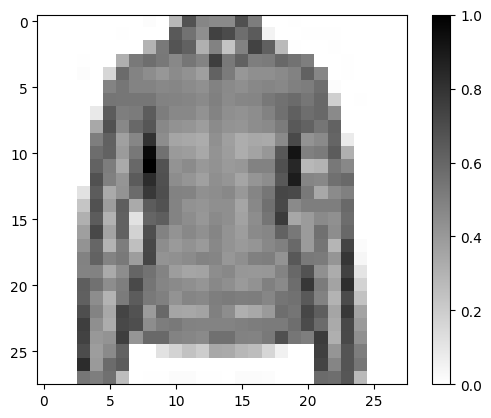

In [32]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
    image = image.numpy().reshape((28, 28))
    break


# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

# Verify that the data is in the correct format by displaying first 25 images

2024-09-25 21:39:35.397154: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-25 21:39:35.397388: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


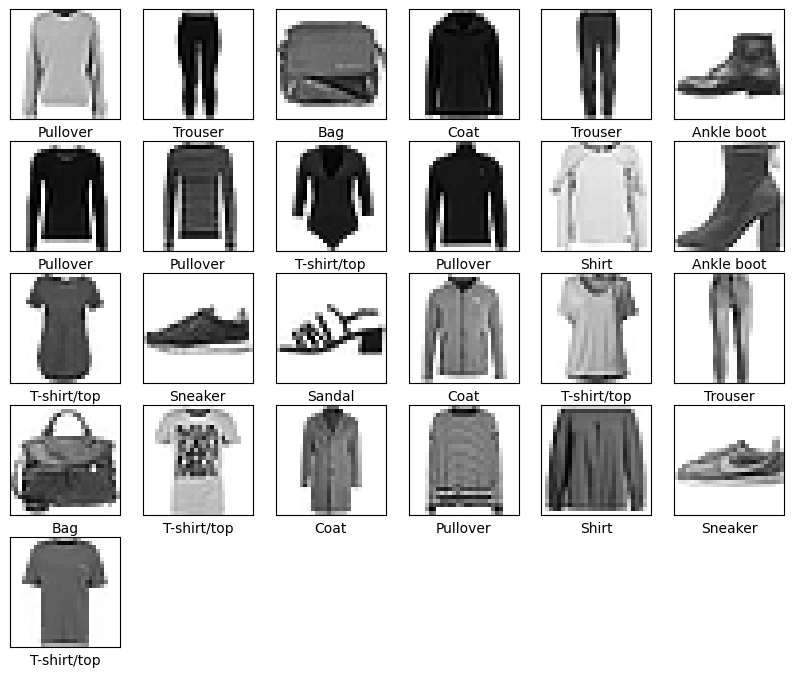

In [33]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(25)):
    image = image.numpy().reshape((28, 28))
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

# Build the model

## Setup the layers

In [34]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax),
    ]
)

/home/omar/miniconda3/envs/.tf217/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compile the model

In [35]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

# Train the model

In [36]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [37]:
model.fit(
    train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE)
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7881 - loss: 0.6138
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8636 - loss: 0.3834
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8730 - loss: 0.3458
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8840 - loss: 0.3155
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8893 - loss: 0.2999


# Evaluate accuracy

In [38]:
test_loss, test_accuracy = model.evaluate(
    test_dataset, steps=math.ceil(num_test_examples / 32)
)
print("Accuracy on test dataset:", test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8644 - loss: 0.3685
Accuracy on test dataset: 0.8626000285148621


# Make predictions and explore

In [39]:
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


2024-09-25 21:40:05.632537: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [40]:
predictions.shape

(32, 10)

In [41]:
predictions[0]

array([8.1344660e-05, 1.0804190e-06, 1.5511359e-02, 4.4453859e-07,
       9.0451902e-01, 2.9087721e-08, 7.9835556e-02, 3.1537102e-08,
       5.0981824e-05, 1.6137075e-07], dtype=float32)

In [42]:
np.argmax(predictions[0])

4

In [43]:
test_labels[0]

4

# Plotting Function

In [44]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[..., 0], cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = "blue"
    else:
        color = "red"

    plt.xlabel(
        "{} {:2.0f}% ({})".format(
            class_names[predicted_label],
            100 * np.max(predictions_array),
            class_names[true_label],
        ),
        color=color,
    )


def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color("red")
    thisplot[true_label].set_color("blue")

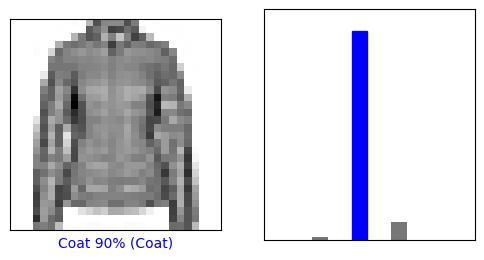

In [45]:
i = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

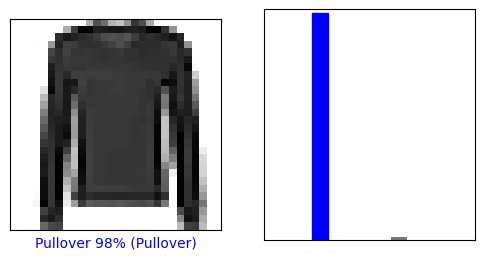

In [46]:
i = 12
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

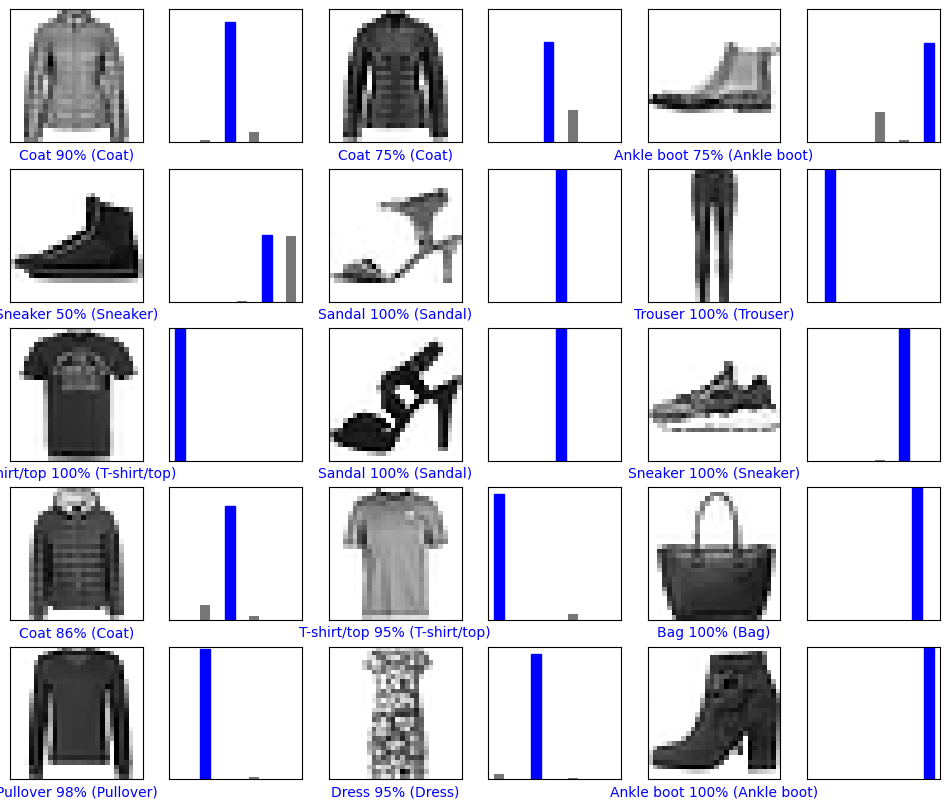

In [47]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions, test_labels)

In [48]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [49]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [50]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
[[8.13445949e-05 1.08041911e-06 1.55113535e-02 4.44538642e-07
  9.04519141e-01 2.90876692e-08 7.98354819e-02 3.15370450e-08
  5.09818274e-05 1.61370764e-07]]


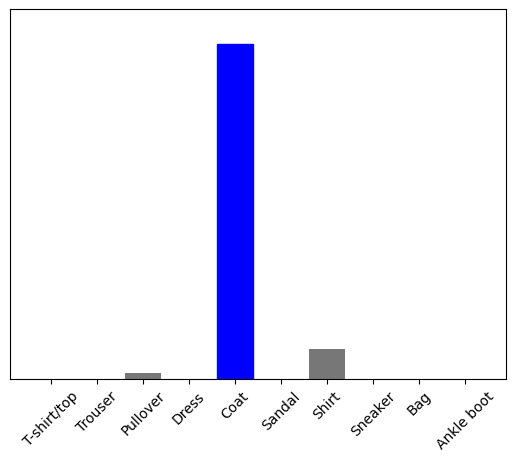

In [51]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)